In [1]:
from lol_data import get_summoner_lol_data, get_match_ids, get_match_data, calculate_win_percentage_per_role
from lol_visuals import visualize_win_percentages, plot_win_percentage_over_time
from config import API_KEY

summoner_name = input("Enter Summoner Name: ")
region = input("Enter Region (e.g., na1, euw1): ")
queue_type = input("Enter Queue Type (e.g., ranked_solo_duo): ")

# ... (bestaande code blijft hetzelfde)
summoner_data = get_summoner_lol_data(API_KEY, summoner_name, region)
match_ids = get_match_ids(API_KEY, summoner_data['puuid'], region, queue_type, count=50)
if summoner_data:
    print(f"Summoner name: {summoner_data['name']}")
    print(f"Summoner Level: {summoner_data['summonerLevel']}")
    print(f"Below is the data analyses for {summoner_name} in {queue_type}:")
    match_ids = get_match_ids(API_KEY, summoner_data['puuid'], region, queue_type)
    if match_ids:
        matches = []
        for match_id in match_ids:
            match_data = get_match_data(API_KEY, match_id, region)
            if match_data:
                matches.append(match_data)
            else:
                print(f"Error fetching match data for match ID {match_id}")


Summoner name: Kiirbb
Summoner Level: 265
Below is the data analyses for kiirbb in ranked_solo_duo:


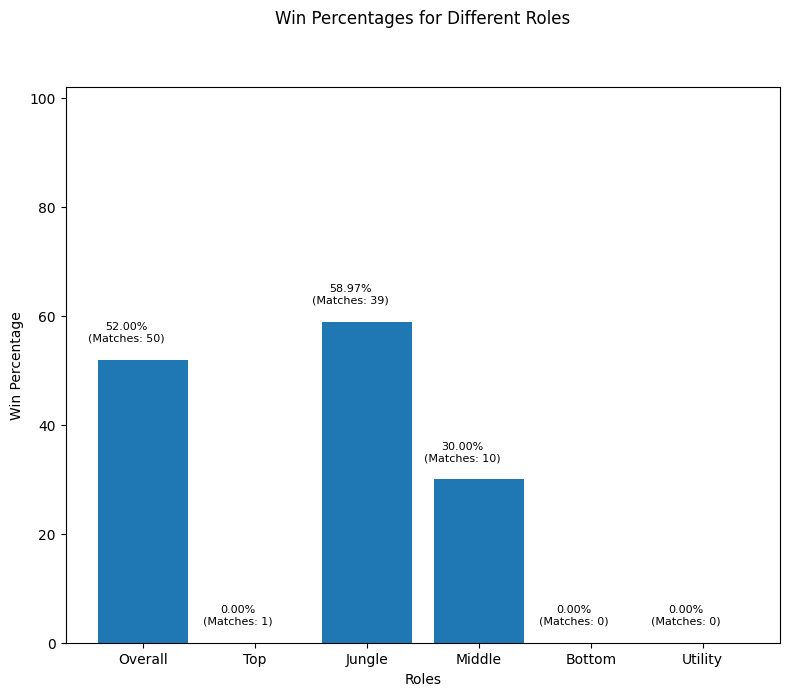

In [2]:
win_percentages = calculate_win_percentage_per_role(matches, summoner_data['puuid'])
visualize_win_percentages(win_percentages)


Total games in the last two weeks for this queue type: 23


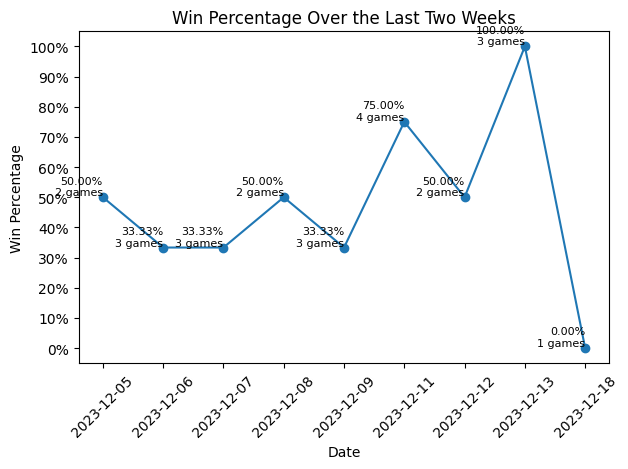

In [3]:
plot_win_percentage_over_time(matches, summoner_data)
